In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os 
import pandas as pd
from datetime import datetime
from signaltk import constants as cst

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300

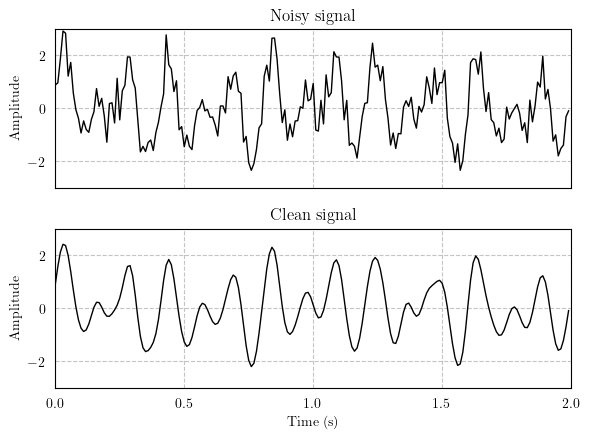

In [2]:
np.random.seed(0)  # For reproducibility

# --- Signal Parameters ---
frequency = 5  # Hz
amplitude = 1.0
sampling_rate = 100  # Samples per second
duration = 2  # Seconds

# --- Generate Time Vector ---
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# --- Generate Clean Sine Wave (sum of two frequencies for more complexity) ---
clean_signal = amplitude * np.sin(2 * np.pi * frequency * t) + amplitude * np.sin(2 * np.pi * frequency * 1.5 * t)

# --- Generate Noise ---
# Mean of the Gaussian noise (typically 0 for white noise)
noise_mean = 0
# Standard deviation of the Gaussian noise (controls noise intensity)
noise_std_dev = 0.5
noise = np.random.normal(noise_mean, noise_std_dev, len(t))

# --- Add Noise to Signal ---
noisy_signal = clean_signal + noise

# --- Butterworth Low-pass Filter Design ---
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.25 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# --- Filter Parameters ---
cutoff = 7  # Hz, just above the signal frequency
order = 4

# --- Apply Low-pass Filter to Noisy Signal ---
filtered_signal = butter_lowpass_filter(noisy_signal, cutoff, sampling_rate, order)


# --- Plotting to match the pasted image ---
fig, axs = plt.subplots(nrows=2, figsize=(6, 4.5), sharex=True, sharey=True)

axs[0].plot(t, noisy_signal, 'k', linewidth=1, zorder=25)
axs[0].set_title('Noisy signal')
axs[0].set_ylabel('Amplitude')

axs[1].plot(t, filtered_signal, 'k', linewidth=1, zorder=25)
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Clean signal')

for ax in axs:
    ax.set_xlim(0, duration)
    ax.set_ylim(-3, 3)
    ax.set_xticks(np.arange(0, duration + 0.5, 0.5))
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/signal_illustration.pdf", dpi=DPI, transparent=True)
plt.show()

### Signals

In [3]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [4]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")

In [5]:
subset = [
    "UNITED AIR LINES INC",
    "APPLE COMPUTER INC",
    "APPLE INC",
    "FORD MOTOR CO",
    "FORD MOTOR CO DEL",
    "WALMART INC",
    "AMERICAN TELEPHONE & TELEG CO",
]

In [6]:
crsp[crsp["comnam"].isin(subset)].xs("2024-12-31")

,comnam,ret,shrout,vol,prc,altprc,exchcd,siccd,ticker,cusip,exchange,industry,ret_adj,excess_ret,dollar_vol,mktcap
permno,,,,,,,,,,,,,,,,
14593,APPLE INC,0.055155,15115823.0,9710426.0,250.42,250.42,3,3571,AAPL,03783310,NASDAQ,Manufacturing,0.055155,0.051455,2431684878.92,3785304395.66
25785,FORD MOTOR CO DEL,-0.110512,3903437.0,12187469.0,9.9,9.9,1,3711,F,34537086,NYSE,Manufacturing,-0.110512,-0.114212,120655943.1,38644026.3
55976,WALMART INC,-0.021,8033386.0,3821318.0,90.35,90.35,1,5311,WMT,93114210,NYSE,Retail,-0.021000,-0.0247,345256081.3,725816425.1


In [7]:
id_mapping = {
    "Apple Inc.": 14593,
    "Walmart Inc": 55976,
}

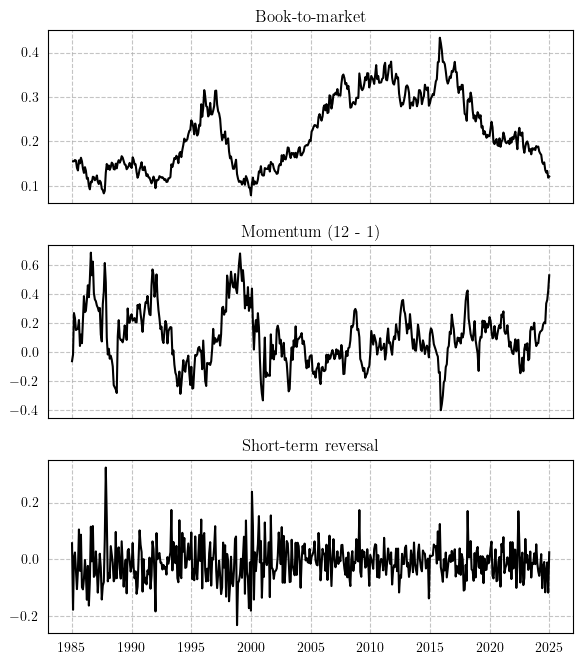

In [8]:
sig = {"b2m": "Book-to-market", "mom_12_1": "Momentum (12 - 1)", "strev": "Short-term reversal"}
_id = 55976  # Walmart Inc.
start_dt = datetime(1984, 12, 31)
fig, axs = plt.subplots(nrows=len(sig), figsize=(6, 2.25 * len(sig)), sharex=True, sharey=False)

for ax, s in zip(axs, sig):
    s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)[s].dropna()
    ax.plot(s_vals, c="black")
    # ax.set_xlim(0, duration)
    # ax.set_ylim(-3, 3)
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.set_title(sig[s])
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/inv_signal_example.pdf", dpi=DPI, transparent=True)
plt.show()

In [9]:
# https://www.mathworks.com/help/ident/ref/iddata.detrend.html

<Axes: >

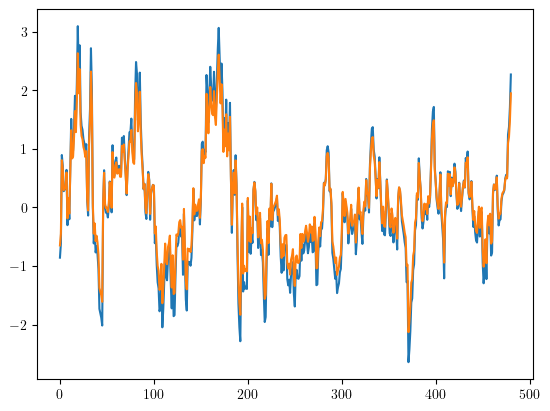

In [10]:
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, Normalizer, KernelCenterer

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = StandardScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = RobustScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

In [11]:
from arch import arch_model



In [12]:
mdl = arch_model(s_vals, vol='Garch', p=1, o=0, q=1)
res = mdl.fit(disp="off")
print(res.summary())
forecasts = res.forecast()
# forecasts.mean

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               mom_12_1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                254.332
Distribution:                  Normal   AIC:                          -500.664
Method:            Maximum Likelihood   BIC:                          -483.961
                                        No. Observations:                  481
Date:                Sun, Jul 20 2025   Df Residuals:                      480
Time:                        19:03:32   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.569e-02      5.450  5.048e-08 [5.476e-0

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [13]:
from arch import arch_model
mdl = arch_model(s_vals, vol='Garch', p=1, o=0, q=1)
res = mdl.fit(disp="off")
res.conditional_volatility

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


1984-12-31    0.215461
1985-01-31    0.164643
1985-02-28    0.125950
1985-03-31    0.179285
1985-04-30    0.159941
                ...   
2024-08-31    0.131133
2024-09-30    0.127920
2024-10-31    0.232622
2024-11-30    0.262170
2024-12-31    0.316881
Freq: ME, Name: cond_vol, Length: 481, dtype: float64

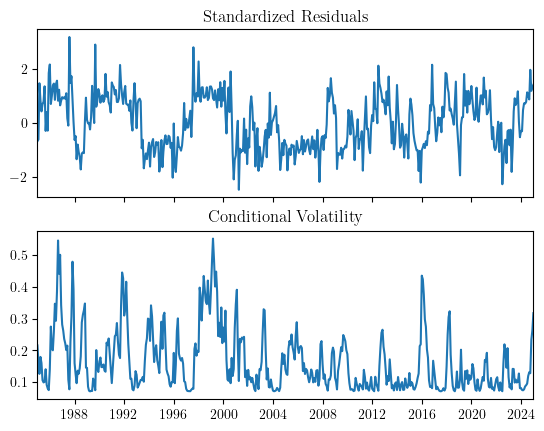

In [14]:
res.plot()
plt.show()

<Axes: >

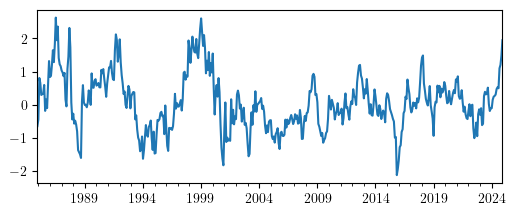

In [15]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"]
transformer = RobustScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame()).flatten(), index=s_vals.index).plot(figsize=(6, 2.25))

In [16]:
forecasts.mean

,h.1
2024-12-31,0.085522


<Axes: >

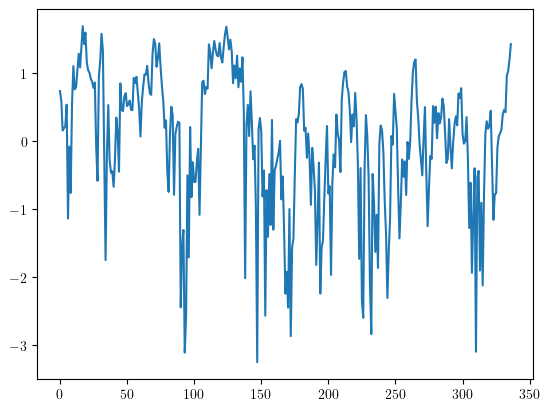

In [17]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna().apply(np.log)
transformer = StandardScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()


<Axes: >

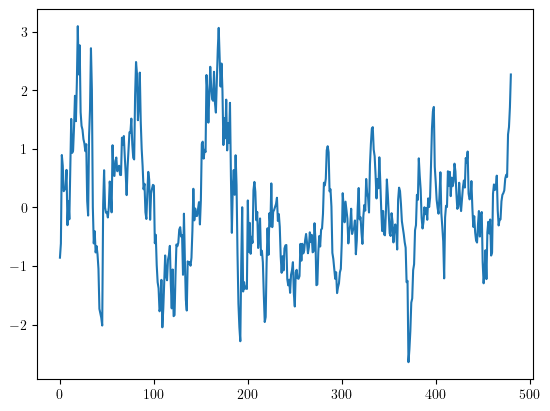

In [18]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = StandardScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

<Axes: >

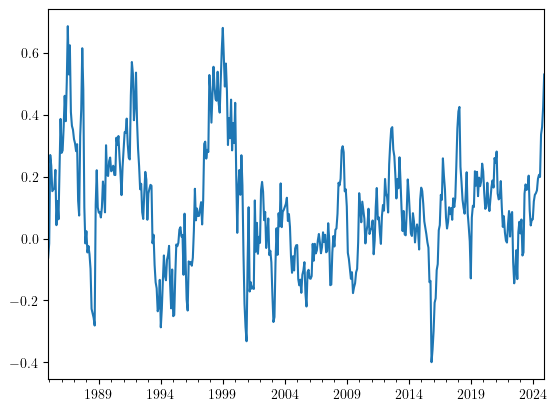

In [19]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
s_vals.plot()

<Axes: >

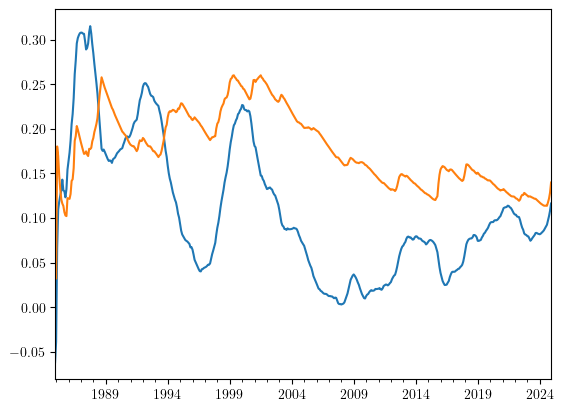

In [20]:
s_vals.ewm(halflife=36).mean().plot()
s_vals.ewm(halflife=36).std().plot()

In [21]:
from scipy.signal import detrend

detrended_data = detrend(s_vals)

<Axes: >

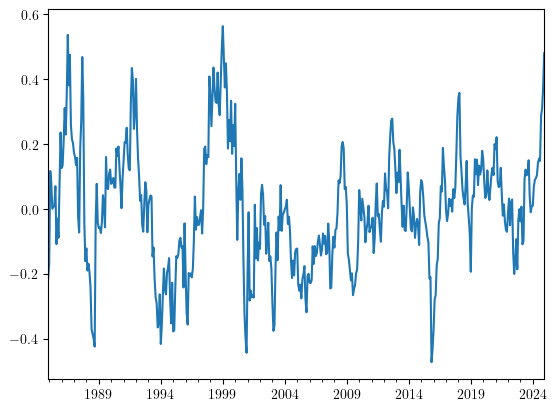

In [22]:
pd.Series(detrended_data, s_vals.index).plot()

<Axes: >

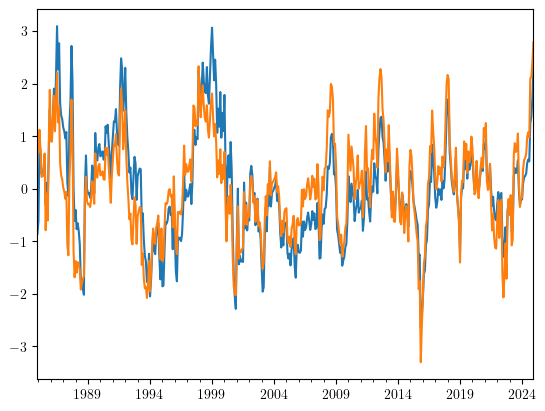

In [23]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"]
transformer = StandardScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten(), index=s_vals.index).plot()
# s_vals.sub(s_vals.expanding().mean()).div(s_vals.expanding().std()).plot()
s_vals.sub(s_vals.ewm(halflife=24).mean()).div(s_vals.ewm(halflife=24).std()).plot()

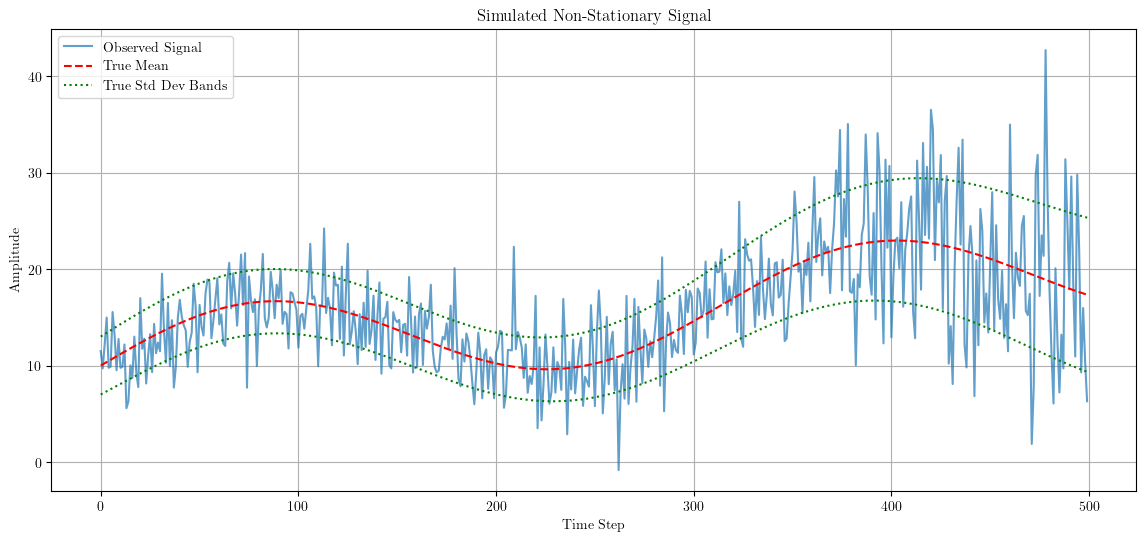

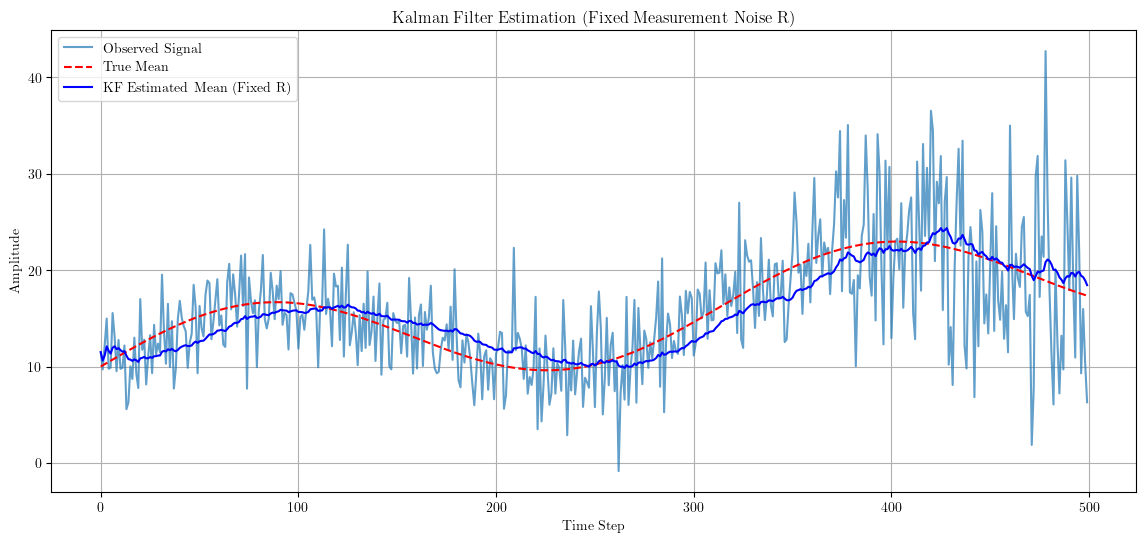

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# --- 1. Simulate a Non-Stationary Signal (same as before) ---
np.random.seed(42)
time_points = 500
t = np.arange(time_points)
true_mean = 10 + 5 * np.sin(t / 50) + 0.02 * t
true_std_dev = 2 + 1 * np.cos(t / 80) + 0.01 * t
true_variance = true_std_dev**2
signal = np.random.normal(loc=true_mean, scale=true_std_dev, size=time_points)

plt.figure(figsize=(14, 6))
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, true_mean + true_std_dev, 'g:', label='True Std Dev Bands')
plt.plot(t, true_mean - true_std_dev, 'g:')
plt.title('Simulated Non-Stationary Signal')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Implement Kalman Filter using pykalman (Fixed R) ---

# State is just the mean (1D)
# Observation is the signal sample (1D)

# Initial state parameters
initial_state_mean = np.array([signal[0]])
initial_state_covariance = np.array([[100.0]]) # High uncertainty

# Transition matrix (F): mean follows a random walk, so 1*mean
transition_matrices = np.array([[1]])

# Process noise covariance (Q_mu): how much we expect the mean to change per step
# Tune this value based on expected mean variability
transition_covariance = np.array([[0.01]]) # Same as Q_mu from manual example

# Observation matrix (H): observation is directly the mean
observation_matrices = np.array([[1]])

# Measurement noise covariance (R): THIS IS THE FIXED R.
# We'll use the variance of the first part of the signal as a rough estimate.
# This will NOT adapt to true_std_dev changes.
fixed_observation_covariance = np.array([[np.var(signal[:20])]]) # Example: Use initial variance

kf = KalmanFilter(
    transition_matrices=transition_matrices,
    observation_matrices=observation_matrices,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    transition_covariance=transition_covariance,
    observation_covariance=fixed_observation_covariance
)

# Apply the filter to the observed signal
# The 'filter' method computes the filtered state means and covariances for all observations
(filtered_state_means, filtered_state_covariances) = kf.filter(signal)

# The filtered_state_means[:, 0] gives us the estimated mean
mean_estimates_fixed_R = filtered_state_means[:, 0]

# --- 3. Plotting Results (Fixed R) ---
plt.figure(figsize=(14, 6))
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, mean_estimates_fixed_R, 'b-', label='KF Estimated Mean (Fixed R)')
plt.title('Kalman Filter Estimation (Fixed Measurement Noise R)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Note: With fixed R, we don't get an estimate of time-varying std_dev directly from the filter.
# The error covariance (P) of the state (mean) is estimated, but not the signal's own std_dev (R).

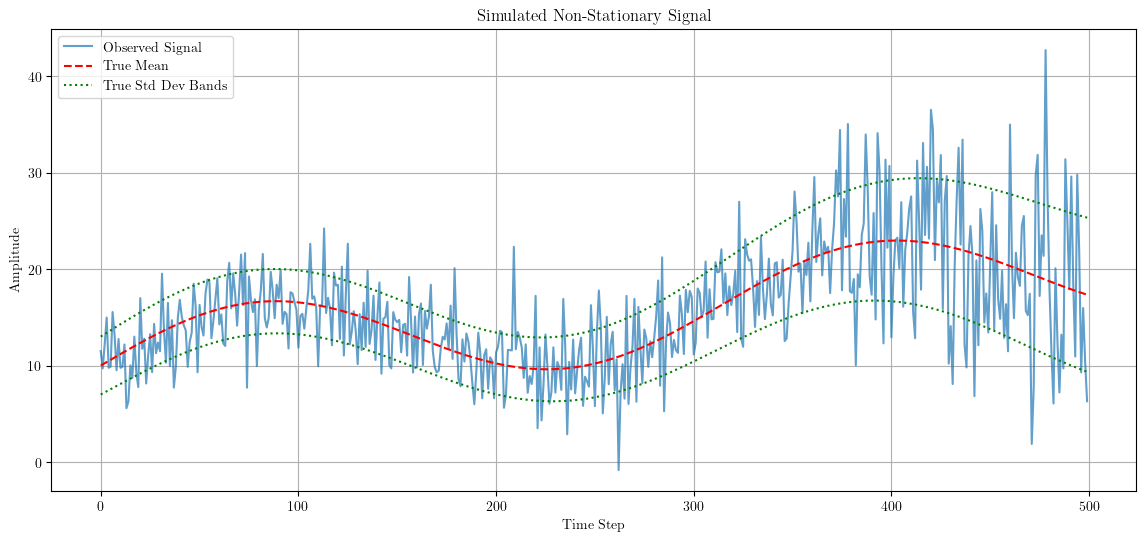

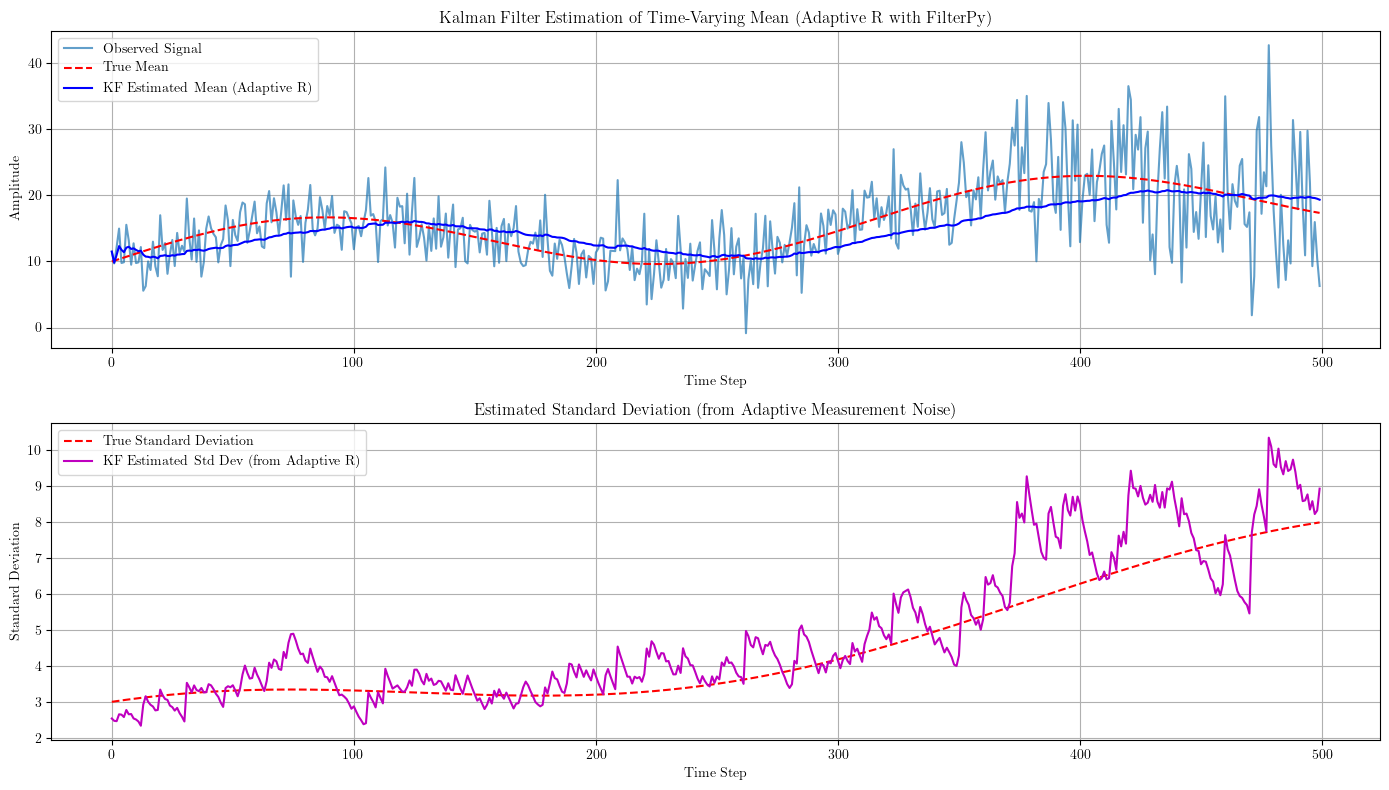

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# --- 1. Simulate a Non-Stationary Signal (same as before) ---
np.random.seed(42) # For reproducibility

time_points = 500
t = np.arange(time_points)

# Time-varying mean
true_mean = 10 + 5 * np.sin(t / 50) + 0.02 * t

# Time-varying standard deviation (heteroscedasticity)
true_std_dev = 2 + 1 * np.cos(t / 80) + 0.01 * t
true_variance = true_std_dev**2 # Store variance for comparison

# Generate the signal
signal = np.random.normal(loc=true_mean, scale=true_std_dev, size=time_points)

plt.figure(figsize=(14, 6))
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, true_mean + true_std_dev, 'g:', label='True Std Dev Bands')
plt.plot(t, true_mean - true_std_dev, 'g:')
plt.title('Simulated Non-Stationary Signal')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# --- 2. Implement the Adaptive Kalman Filter using filterpy ---

# Initialize the KalmanFilter object
# State dimension (dim_x) = 1 (for mean)
# Measurement dimension (dim_z) = 1 (for signal sample)
kf = KalmanFilter(dim_x=1, dim_z=1)

# Initial state estimation (x) and its covariance (P)
kf.x = np.array([[signal[0]]]) # Initial estimate of the mean
kf.P = np.array([[100.0]])   # High initial uncertainty in mean estimate

# State transition function (F)
# Mean follows a random walk, so F is just 1
kf.F = np.array([[1.]])

# Measurement function (H)
# Observation is directly the mean, so H is just 1
kf.H = np.array([[1.]])

# Process noise covariance (Q)
# Represents how much the true mean is allowed to change between steps
# Tune this value: larger Q means filter trusts new measurements more.
Q_mu_scalar = 0.01 # Same as Q_mu from previous examples
kf.Q = np.array([[Q_mu_scalar]])

# Adaptive R_k parameters
# Initial estimate of measurement noise covariance (R_k)
# Use variance of initial segment as a start
R_k_scalar = np.var(signal[:20])
kf.R = np.array([[R_k_scalar]]) # Set initial R for the filter

# alpha_R = 0.05 # Smoothing factor for R_k adaptation (0 to 1)
alpha_R = 0.10 # Smoothing factor for R_k adaptation (0 to 1)

# Store results
mean_estimates = [kf.x[0,0]] # Initial mean estimate
std_dev_estimates = [] # We'll derive this from the adaptive R_k

# Main Kalman Filter Loop
for i in range(1, time_points):
    z_k = signal[i] # Current observation

    # --- Prediction Step ---
    kf.predict()

    # --- Update Step ---
    kf.update(z_k)

    # Store estimated mean
    mean_estimates.append(kf.x[0,0])

    # --- Adapt R_k (Measurement Noise Covariance) ---
    # The innovation (measurement residual) for the current step is stored in kf.y
    innovation = kf.y[0,0]

    # Update R_k using EWMA of squared innovations
    R_k_scalar = alpha_R * (innovation**2) + (1 - alpha_R) * R_k_scalar
    kf.R = np.array([[R_k_scalar]]) # Update filter's R for the next iteration

    # Store the square root of R_k as our estimated standard deviation
    std_dev_estimates.append(np.sqrt(R_k_scalar))

# Pad std_dev_estimates for the initial point (since it starts from i=1)
std_dev_estimates.insert(0, np.sqrt(np.var(signal[:20]))) # Use initial R_k's sqrt

# --- 3. Plotting Results ---
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, mean_estimates, 'b-', label='KF Estimated Mean (Adaptive R)')
plt.title('Kalman Filter Estimation of Time-Varying Mean (Adaptive R with FilterPy)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, true_std_dev, 'r--', label='True Standard Deviation')
plt.plot(t, std_dev_estimates, 'm-', label='KF Estimated Std Dev (from Adaptive R)')
plt.title('Estimated Standard Deviation (from Adaptive Measurement Noise)')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Axes: >

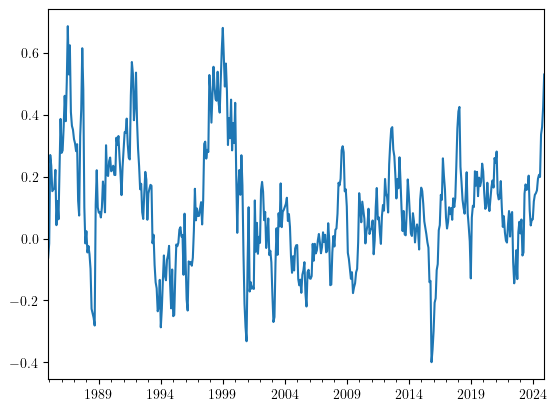

In [26]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
s_vals.plot()

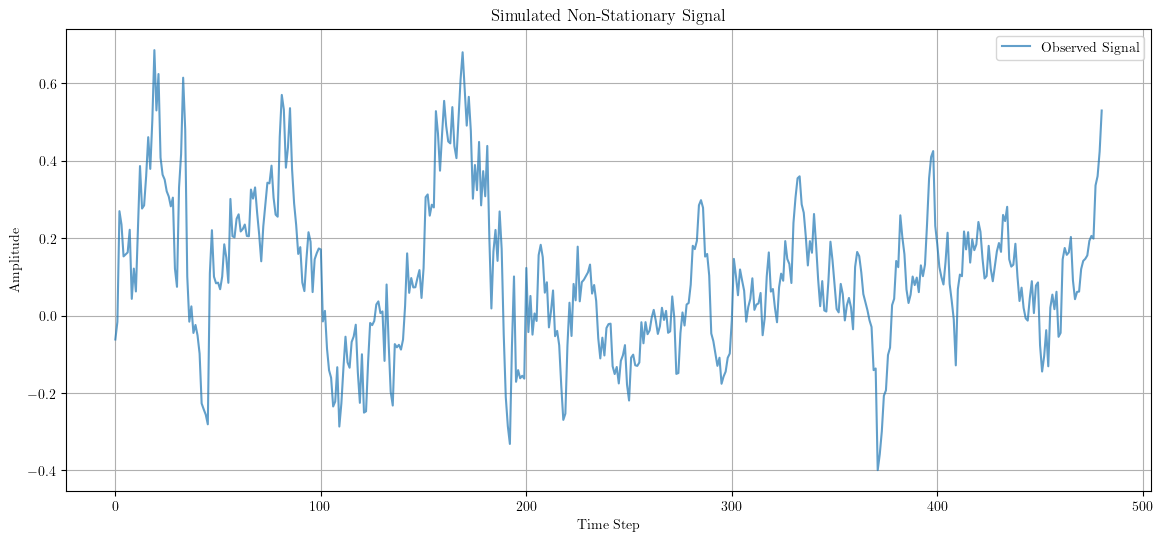

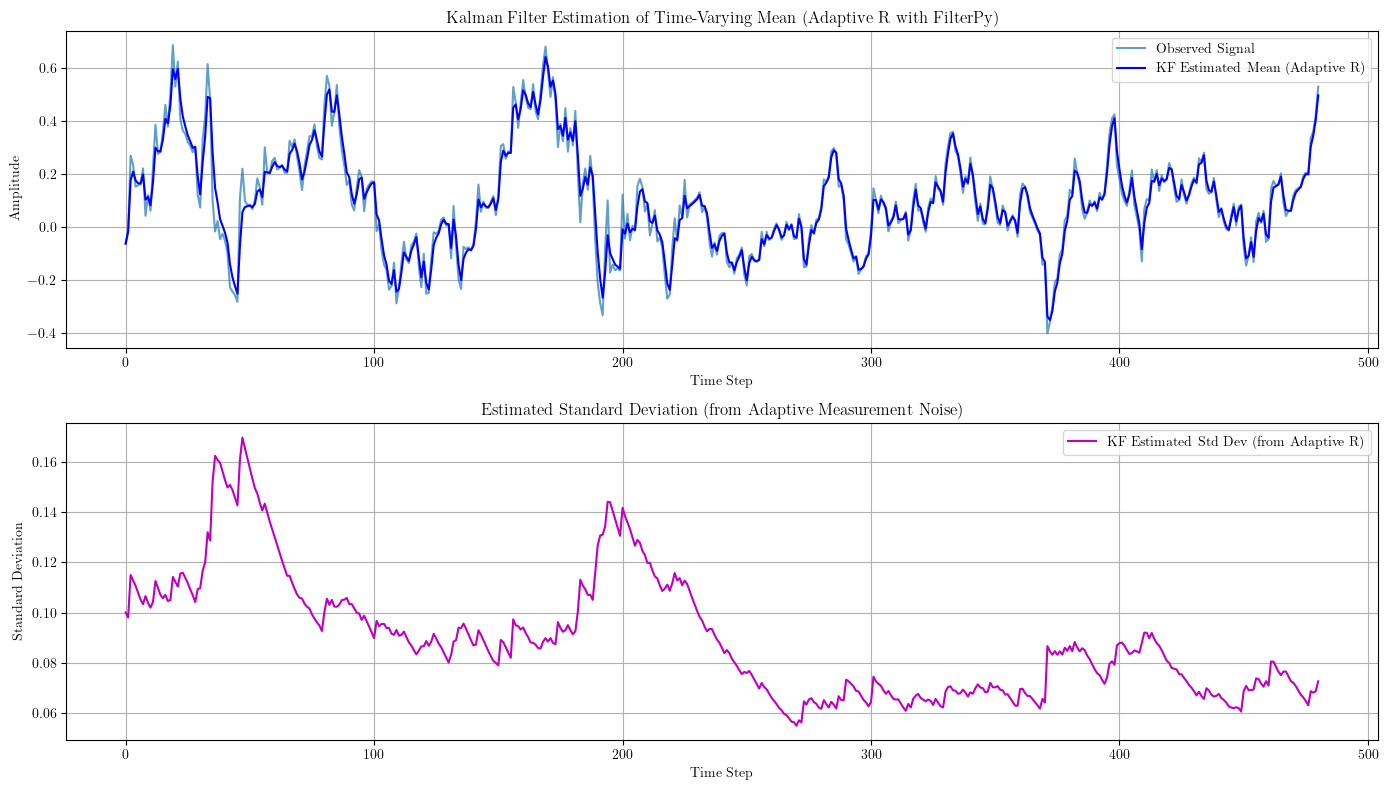

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# --- 1. Simulate a Non-Stationary Signal (same as before) ---
np.random.seed(42) # For reproducibility

time_points = len(s_vals)
t = np.arange(time_points)

# Time-varying mean
true_mean = 10 + 5 * np.sin(t / 50) + 0.02 * t

# Time-varying standard deviation (heteroscedasticity)
true_std_dev = 2 + 1 * np.cos(t / 80) + 0.01 * t
true_variance = true_std_dev**2 # Store variance for comparison

# Generate the signal
signal = s_vals.values

plt.figure(figsize=(14, 6))
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
# plt.plot(t, true_mean, 'r--', label='True Mean')
# plt.plot(t, true_mean + true_std_dev, 'g:', label='True Std Dev Bands')
# plt.plot(t, true_mean - true_std_dev, 'g:')
plt.title('Simulated Non-Stationary Signal')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# --- 2. Implement the Adaptive Kalman Filter using filterpy ---

# Initialize the KalmanFilter object
# State dimension (dim_x) = 1 (for mean)
# Measurement dimension (dim_z) = 1 (for signal sample)
kf = KalmanFilter(dim_x=1, dim_z=1)

# Initial state estimation (x) and its covariance (P)
kf.x = np.array([[signal[0]]]) # Initial estimate of the mean
kf.P = np.array([[100.0]])   # High initial uncertainty in mean estimate

# State transition function (F)
# Mean follows a random walk, so F is just 1
kf.F = np.array([[1.]])

# Measurement function (H)
# Observation is directly the mean, so H is just 1
kf.H = np.array([[1.]])

# Process noise covariance (Q)
# Represents how much the true mean is allowed to change between steps
# Tune this value: larger Q means filter trusts new measurements more.
Q_mu_scalar = 0.01 # Same as Q_mu from previous examples
kf.Q = np.array([[Q_mu_scalar]])

# Adaptive R_k parameters
# Initial estimate of measurement noise covariance (R_k)
# Use variance of initial segment as a start
R_k_scalar = np.var(signal[:12])
kf.R = np.array([[R_k_scalar]]) # Set initial R for the filter

alpha_R = .05 # Smoothing factor for R_k adaptation (0 to 1)
# alpha_R = 0.10 # Smoothing factor for R_k adaptation (0 to 1)

# Store results
mean_estimates = [kf.x[0,0]] # Initial mean estimate
std_dev_estimates = [] # We'll derive this from the adaptive R_k

# Main Kalman Filter Loop
for i in range(1, time_points):
    z_k = signal[i] # Current observation

    # --- Prediction Step ---
    kf.predict()

    # --- Update Step ---
    kf.update(z_k)

    # Store estimated mean
    mean_estimates.append(kf.x[0,0])

    # --- Adapt R_k (Measurement Noise Covariance) ---
    # The innovation (measurement residual) for the current step is stored in kf.y
    innovation = kf.y[0,0]

    # Update R_k using EWMA of squared innovations
    R_k_scalar = alpha_R * (innovation**2) + (1 - alpha_R) * R_k_scalar
    kf.R = np.array([[R_k_scalar]]) # Update filter's R for the next iteration

    # Store the square root of R_k as our estimated standard deviation
    std_dev_estimates.append(np.sqrt(R_k_scalar))

# Pad std_dev_estimates for the initial point (since it starts from i=1)
std_dev_estimates.insert(0, np.sqrt(np.var(signal[:12]))) # Use initial R_k's sqrt

# --- 3. Plotting Results ---
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
# plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, mean_estimates, 'b-', label='KF Estimated Mean (Adaptive R)')
plt.title('Kalman Filter Estimation of Time-Varying Mean (Adaptive R with FilterPy)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
# plt.plot(t, true_std_dev, 'r--', label='True Standard Deviation')
plt.plot(t, std_dev_estimates, 'm-', label='KF Estimated Std Dev (from Adaptive R)')
plt.title('Estimated Standard Deviation (from Adaptive Measurement Noise)')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Axes: >

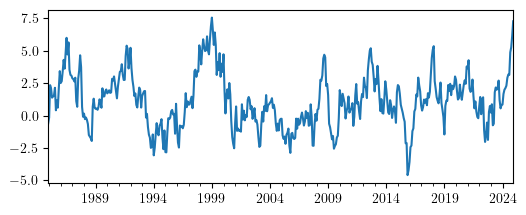

In [28]:
xx = s_vals.div(pd.Series(std_dev_estimates, index=s_vals.index))
xx.plot(figsize=(6, 2.25))

<Axes: >

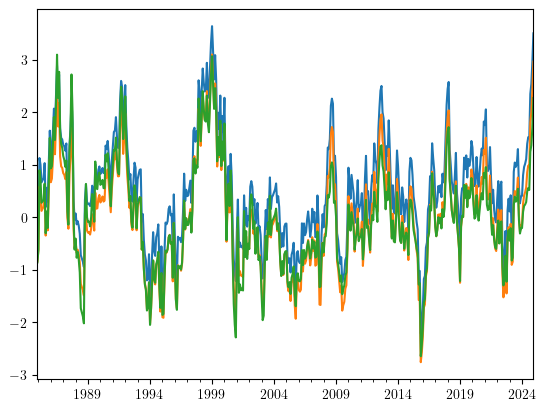

In [29]:
(xx / xx.std()).plot()
transformer = StandardScaler().fit(xx.to_frame())
pd.Series(transformer.transform(xx.to_frame()).flatten(), index=s_vals.index).plot()

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"]
transformer = StandardScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame()).flatten(), index=s_vals.index).plot()
# s_vals.sub(s_vals.expanding().mean()).div(s_vals.expanding().std()).plot()
# s_vals.sub(s_vals.ewm(halflife=24).mean()).div(s_vals.ewm(halflife=24).std()).plot()

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Axes: >

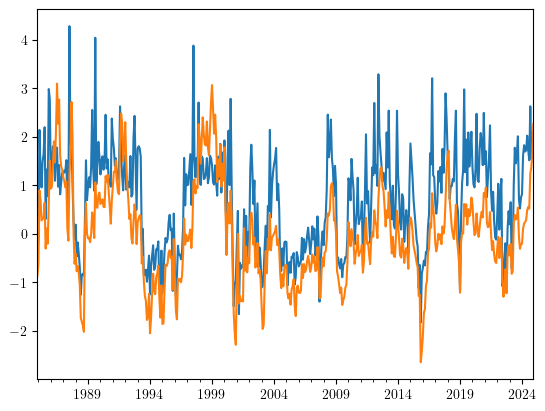

In [30]:
from arch import arch_model

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"]
mdl = arch_model(s_vals, vol='Garch', p=1, o=0, q=1)
res = mdl.fit(disp="off")
res.conditional_volatility


xx = s_vals.div(pd.Series(res.conditional_volatility, index=res.conditional_volatility.index))
xx.plot()

transformer = StandardScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame()).flatten(), index=s_vals.index).plot()

<Axes: >

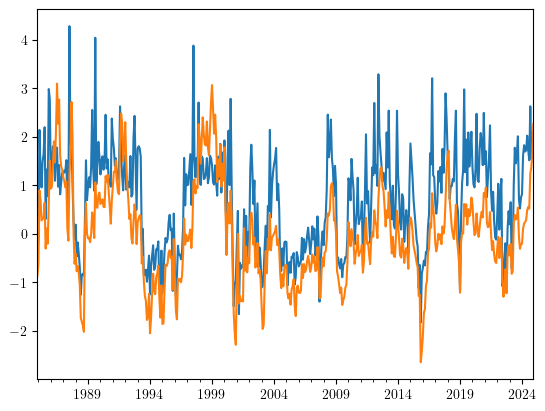

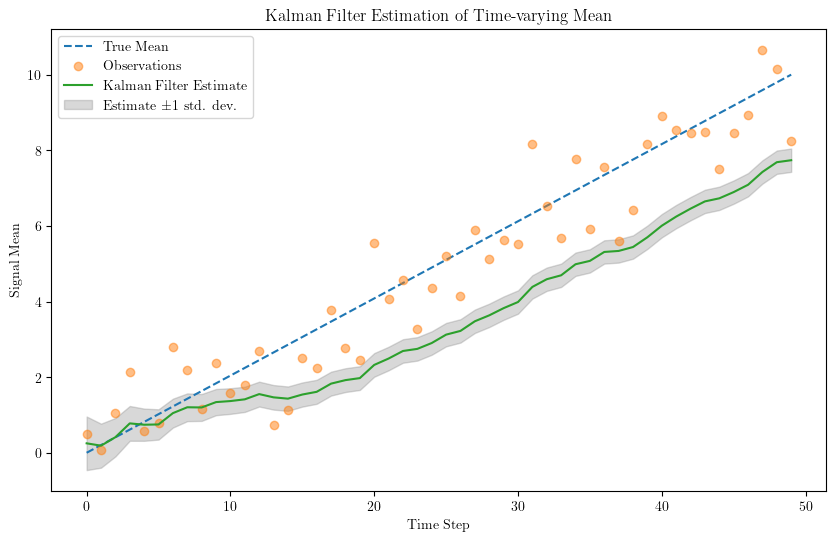

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
timesteps = 50
true_mean = np.linspace(0, 10, timesteps)
measurement_noise_std = 1.0

observations = true_mean + np.random.normal(0, measurement_noise_std, timesteps)

# Kalman Filter Setup:
A = 1             # Transition matrix (scalar)
H = 1             # Observation matrix (scalar)
Q = 0.01          # Transition variance (process noise)
R = measurement_noise_std**2  # Measurement variance

# Initial guesses
mu_estimate = 0
P_estimate = 1.0

# Storage for estimates
mu_filtered = np.zeros(timesteps)
P_filtered = np.zeros(timesteps)

# Kalman filtering loop
for k in range(timesteps):
    # Prediction
    mu_pred = A * mu_estimate
    P_pred = A * P_estimate * A + Q

    # Kalman Gain
    K = P_pred * H / (H * P_pred * H + R)

    # Update
    mu_estimate = mu_pred + K * (observations[k] - H * mu_pred)
    P_estimate = (1 - K * H) * P_pred

    # Store results
    mu_filtered[k] = mu_estimate
    P_filtered[k] = P_estimate

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_mean, label='True Mean', linestyle='--')
plt.plot(observations, 'o', alpha=0.5, label='Observations')
plt.plot(mu_filtered, label='Kalman Filter Estimate')
plt.fill_between(range(timesteps),
                 mu_filtered - np.sqrt(P_filtered),
                 mu_filtered + np.sqrt(P_filtered),
                 color='gray', alpha=0.3, label='Estimate ±1 std. dev.')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Signal Mean')
plt.title('Kalman Filter Estimation of Time-varying Mean')
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Generate the time series data
dt = 0.1
t = np.arange(0, 20, dt)
true_signal = np.sin(t * 0.9)
# Add noise to create our measurements
measurements = true_signal + np.random.randn(len(t)) * 0.3

In [34]:
# 1. Define the state transition and measurement functions
# Our state is just [value], so the state transition is x_k = x_{k-1}
def f_x(x, dt):
    return np.array([x[0]])

# Our measurement is a direct observation of the state
def h_x(x):
    return np.array([x[0]])

# 2. Initialize the UKF
# Create sigma points
# n=1 (state dimension), alpha=.1, beta=2., kappa=0 (avoid division by zero for n=1)
points = MerweScaledSigmaPoints(n=1, alpha=0.1, beta=2.0, kappa=-1.0)

ukf = UnscentedKalmanFilter(
    dim_x=1,        # State is 1D (the value)
    dim_z=1,        # Measurement is 1D (the value)
    dt=dt,
    fx=f_x,
    hx=h_x,
    points=points
)

# 3. Set initial conditions and noise
ukf.x = np.array([0.])      # Initial state (mean)
ukf.P = np.array([[1.]])    # Initial state covariance (variance)
ukf.R = np.array([[0.09]])  # Measurement noise variance (0.3^2)
ukf.Q = Q_discrete_white_noise(dim=1, dt=dt, var=0.05) # Process noise

# 4. Run the filter
means = []
variances = []

for z in measurements:
    ukf.predict()
    ukf.update(z)
    means.append(ukf.x[0])
    # The conditional variance is the diagonal of the covariance matrix P
    variances.append(ukf.P[0, 0])

means = np.array(means)
variances = np.array(variances)

ZeroDivisionError: float division by zero

In [27]:
# Calculate the standard deviation for the confidence interval
std_dev = np.sqrt(variances)

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

# Plot measurements
plt.plot(t, measurements, 'x', color='lightgray', label='Noisy Measurements', markersize=4)

# Plot true signal
plt.plot(t, true_signal, 'k-', lw=2, label='True Signal')

# Plot UKF estimate (conditional mean)
plt.plot(t, means, 'b-', lw=2, label='UKF Estimate (Conditional Mean)')

# Plot confidence interval (derived from conditional variance)
plt.fill_between(t, means - 2 * std_dev, means + 2 * std_dev, color='b', alpha=0.2, label='95% Confidence Interval (Variance)')

# Formatting
plt.title('UKF Estimation of a Time Series', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Signal Value', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

NameError: name 'variances' is not defined

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

np.random.seed(42)

# Generate synthetic time series data with increasing mean and variance
timesteps = 100
true_mean = np.linspace(0, 10, timesteps)
true_variance = np.linspace(1, 5, timesteps)
true_std = np.sqrt(true_variance)
observations = true_mean + np.random.normal(0, true_std)

# UKF Functions
def fx(x, dt):
    # State transition function (random walk)
    return x

def hx(x):
    # Measurement function (observation directly depends on mean)
    return x[0]

# Initialize sigma points
points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2., kappa=-1.)

# Initialize UKF
ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1, fx=fx, hx=hx, points=points)

ukf.x = np.array([0., np.log(1.)])  # Initial state: mean, log(variance)
ukf.P = np.eye(2)                   # Initial covariance
ukf.Q = np.diag([0.05, 0.01])       # Process noise
ukf.R = 1.0                         # Initial measurement noise (will update dynamically)

# Storage arrays
ukf_mean = np.zeros(timesteps)
ukf_variance = np.zeros(timesteps)

for k in range(timesteps):
    # Dynamically update observation noise variance
    ukf.R = np.exp(ukf.x[1])

    # UKF predict and update steps
    ukf.predict()
    ukf.update(observations[k])

    # Store estimates
    ukf_mean[k] = ukf.x[0]
    ukf_variance[k] = np.exp(ukf.x[1])

# Plotting results
plt.figure(figsize=(12, 8))

# Mean Estimation
plt.subplot(2, 1, 1)
plt.plot(observations, 'o', alpha=0.4, label='Observations')
plt.plot(true_mean, 'g--', label='True Mean')
plt.plot(ukf_mean, 'r-', label='UKF Estimated Mean')
plt.fill_between(range(timesteps),
                 ukf_mean - np.sqrt(ukf_variance),
                 ukf_mean + np.sqrt(ukf_variance),
                 color='gray', alpha=0.3, label='Estimated Mean ±1 Std Dev')
plt.legend()
plt.title('UKF Estimation of Conditional Mean')
plt.grid()

# Variance Estimation
plt.subplot(2, 1, 2)
plt.plot(true_variance, 'g--', label='True Variance')
plt.plot(ukf_variance, 'b-', label='UKF Estimated Variance')
plt.legend()
plt.title('UKF Estimation of Conditional Variance')
plt.xlabel('Time')
plt.grid()

plt.tight_layout()
plt.show()

[[ 0.   0.1  0.  -0.1  0. ]]


ValueError: shapes (5,) and (1,5) not aligned: 5 (dim 0) != 1 (dim 0)

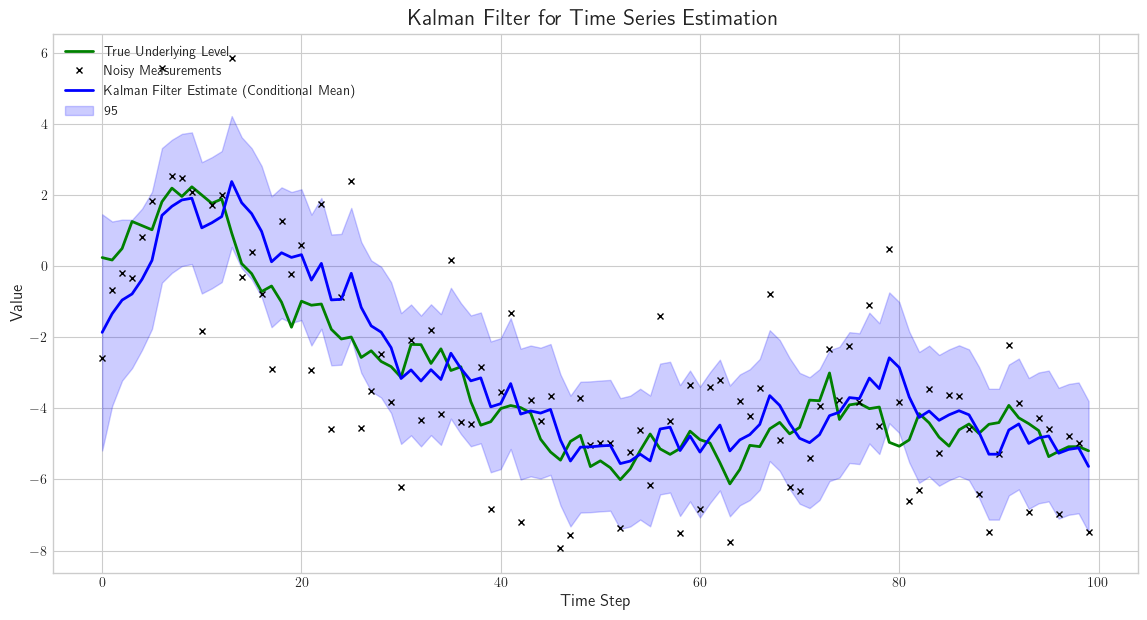

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# For reproducibility
np.random.seed(42)

# 1. Generate Synthetic Time Series Data
n_points = 100
# The true underlying level (a random walk)
true_level = np.cumsum(np.random.randn(n_points) * 0.5)
# The noisy measurements we observe
measurements = true_level + np.random.randn(n_points) * 2.0

# 2. Initialize the Kalman Filter
# We are tracking one variable (the mean), so dim_x=1.
# We are measuring one variable (the value), so dim_z=1.
kf = KalmanFilter(dim_x=1, dim_z=1)

# Define the state-space model matrices
kf.x = np.array([0.])      # Initial state (mean)
kf.P = np.array([[10.]])   # Initial state covariance (uncertainty)
kf.F = np.array([[1.]])    # State transition matrix (mean is random walk)
kf.H = np.array([[1.]])    # Measurement function (we measure the mean directly)
kf.R = np.array([[2.0**2]]) # Measurement noise variance (R)
kf.Q = np.array([[0.5**2]]) # Process noise variance (Q)

# 3. Run the Kalman Filter
# Store the estimated means and variances
estimated_means = np.zeros(n_points)
estimated_variances = np.zeros(n_points)

for t in range(n_points):
    # Predict the next state
    kf.predict()
    
    # Update the state with the new measurement
    kf.update(measurements[t])
    
    # Save the conditional mean and variance
    # estimated_means[t] = kf.x[0, 0]
    estimated_means[t] = kf.x.item()
    estimated_variances[t] = kf.P[0, 0]

# 4. Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate the confidence interval (e.g., 95%)
confidence_interval = 1.96 * np.sqrt(estimated_variances)
upper_bound = estimated_means + confidence_interval
lower_bound = estimated_means - confidence_interval

# Plot the data and the filter's estimates
ax.plot(true_level, 'g-', label='True Underlying Level', linewidth=2)
ax.plot(measurements, 'kx', markersize=5, label='Noisy Measurements')
ax.plot(estimated_means, 'b-', label='Kalman Filter Estimate (Conditional Mean)', linewidth=2)
ax.fill_between(
    range(n_points),
    lower_bound,
    upper_bound,
    color='b',
    alpha=0.2,
    label='95% Confidence Interval (Conditional Variance)'
)

ax.set_title('Kalman Filter for Time Series Estimation', fontsize=16)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
plt.show()

<Axes: >

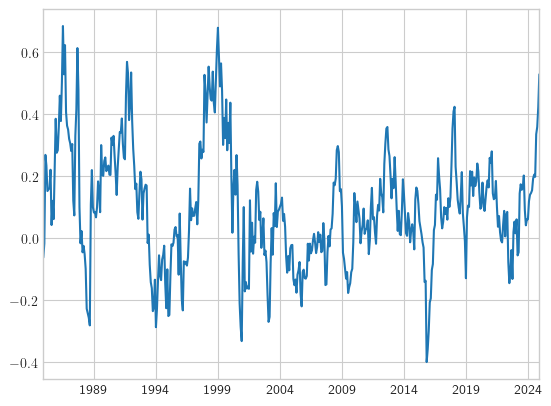

In [36]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
s_vals.plot()

In [39]:
len(s_vals)

481

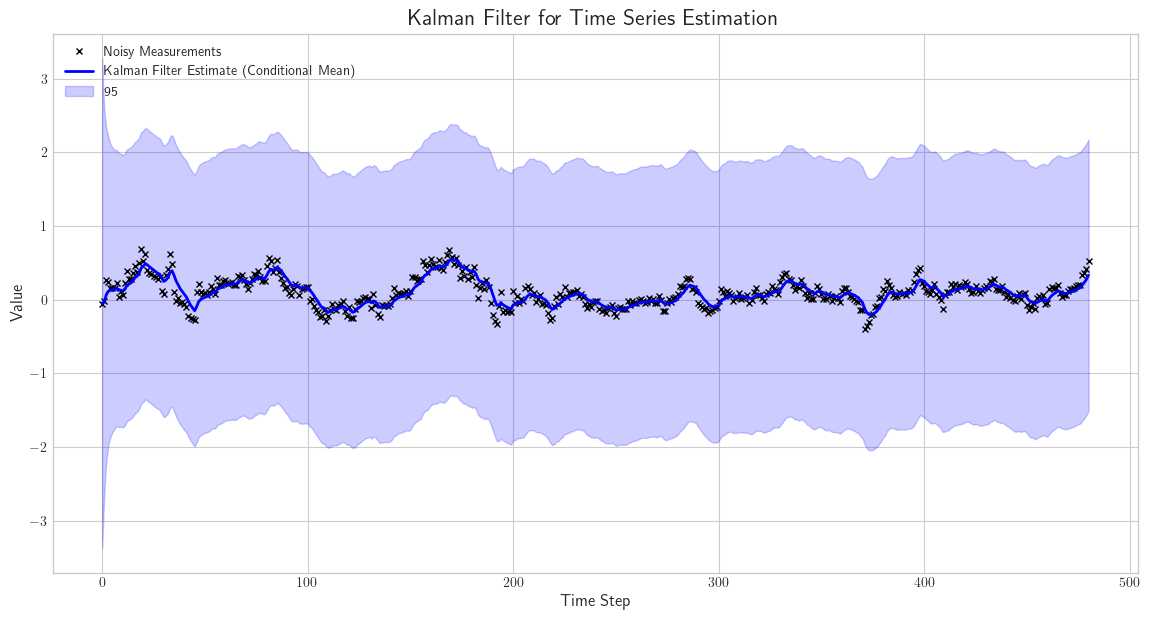

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# For reproducibility
np.random.seed(42)

# 1. Generate Synthetic Time Series Data
# n_points = 100
n_points = len(s_vals)
# The true underlying level (a random walk)
true_level = np.cumsum(np.random.randn(n_points) * 0.5)
# The noisy measurements we observe
measurements = s_vals.values

# 2. Initialize the Kalman Filter
# We are tracking one variable (the mean), so dim_x=1.
# We are measuring one variable (the value), so dim_z=1.
kf = KalmanFilter(dim_x=1, dim_z=1)

# Define the state-space model matrices
kf.x = np.array([0.])      # Initial state (mean)
kf.P = np.array([[10.]])   # Initial state covariance (uncertainty)
kf.F = np.array([[1.]])    # State transition matrix (mean is random walk)
kf.H = np.array([[1.]])    # Measurement function (we measure the mean directly)
kf.R = np.array([[2.0**2]]) # Measurement noise variance (R)
kf.Q = np.array([[0.5**2]]) # Process noise variance (Q)

# 3. Run the Kalman Filter
# Store the estimated means and variances
estimated_means = np.zeros(n_points)
estimated_variances = np.zeros(n_points)

for t in range(n_points):
    # Predict the next state
    kf.predict()
    
    # Update the state with the new measurement
    kf.update(measurements[t])
    
    # Save the conditional mean and variance
    # estimated_means[t] = kf.x[0, 0]
    estimated_means[t] = kf.x.item()
    estimated_variances[t] = kf.P[0, 0]

# 4. Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate the confidence interval (e.g., 95%)
confidence_interval = 1.96 * np.sqrt(estimated_variances)
upper_bound = estimated_means + confidence_interval
lower_bound = estimated_means - confidence_interval

# Plot the data and the filter's estimates
# ax.plot(true_level, 'g-', label='True Underlying Level', linewidth=2)
ax.plot(measurements, 'kx', markersize=5, label='Noisy Measurements')
ax.plot(estimated_means, 'b-', label='Kalman Filter Estimate (Conditional Mean)', linewidth=2)
ax.fill_between(
    range(n_points),
    lower_bound,
    upper_bound,
    color='b',
    alpha=0.2,
    label='95% Confidence Interval (Conditional Variance)'
)

ax.set_title('Kalman Filter for Time Series Estimation', fontsize=16)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
plt.show()

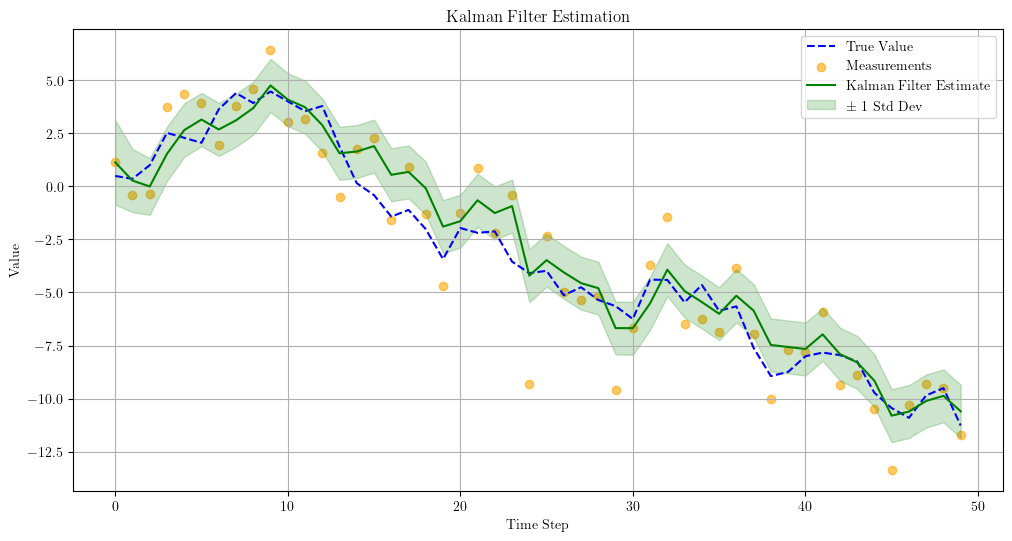

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Generating synthetic data
np.random.seed(42)
timesteps = 50
true_values = np.cumsum(np.random.randn(timesteps))  # true states following random walk
measurements = true_values + np.random.normal(0, 2, size=timesteps)  # noisy observations

# Kalman filter initialization
kf = KalmanFilter(dim_x=1, dim_z=1)

# State transition matrix (assuming state doesn't change significantly)
kf.F = np.array([[1]])

# Measurement function
kf.H = np.array([[1]])

# Initial state estimate
kf.x = np.array([[0]])

# Initial state covariance (large uncertainty initially)
kf.P = np.array([[1000]])

# Process noise covariance (small noise assumed in state transitions)
kf.Q = np.array([[1]])

# Measurement noise covariance
kf.R = np.array([[4]])  # Variance of measurement noise (2² = 4)

# Running the filter through the data
filtered_means = []
filtered_covariances = []

for z in measurements:
    kf.predict()
    kf.update(z)
    
    filtered_means.append(kf.x[0, 0])
    filtered_covariances.append(kf.P[0, 0])

# Visualization of results
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Value', linestyle='--', color='blue')
plt.scatter(range(timesteps), measurements, label='Measurements', color='orange', alpha=0.6)
plt.plot(filtered_means, label='Kalman Filter Estimate', color='green')

# Plotting uncertainty (± 1 std deviation)
std_dev = np.sqrt(filtered_covariances)
plt.fill_between(range(timesteps), 
                 np.array(filtered_means) - std_dev, 
                 np.array(filtered_means) + std_dev,
                 color='green', alpha=0.2, label='± 1 Std Dev')

plt.title('Kalman Filter Estimation')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


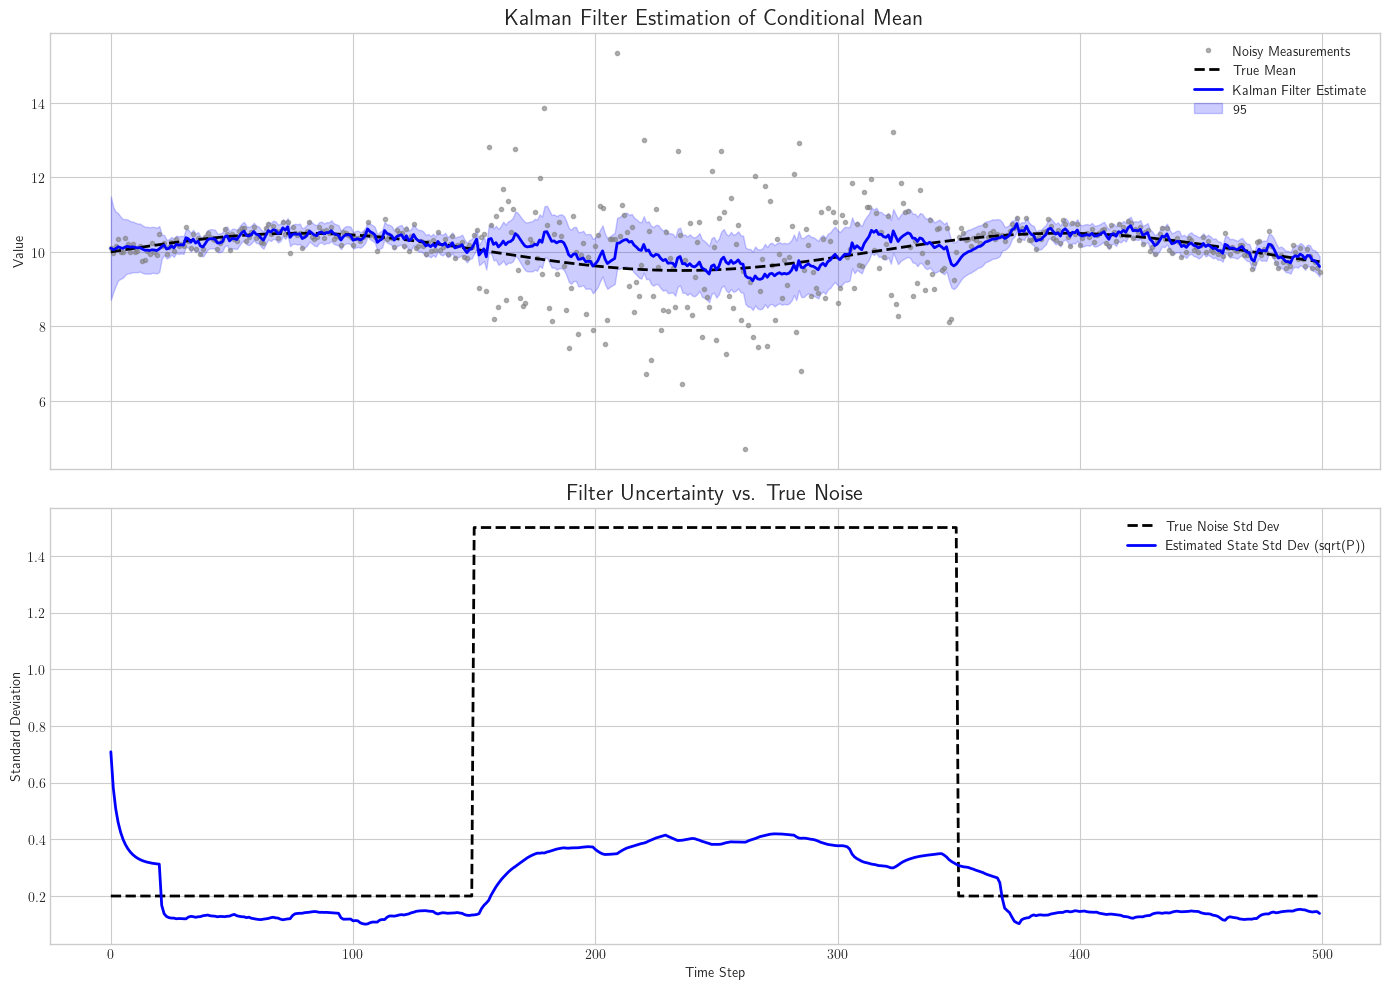

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# For reproducibility
np.random.seed(42)

## ---------------------------------------------------
## Step 1: Generate Synthetic Heteroscedastic Data
## ---------------------------------------------------
# The data will have a true mean that follows a sine wave and two noise regimes.
n_samples = 500
dt = 0.1

# True underlying mean
true_mean = 0.5 * np.sin(np.arange(n_samples) * dt * 0.2) + 10

# Create heteroscedastic noise (low noise -> high noise -> low noise)
noise_std = np.ones(n_samples) * 0.2  # Low noise regime
noise_std[150:350] = 1.5             # High noise regime
noise = np.random.randn(n_samples) * noise_std

# Create the final measured time series
measurements = true_mean + noise

## ---------------------------------------------------
## Step 2: Initialize the Kalman Filter
## ---------------------------------------------------
# We are tracking one variable (the mean), so dim_x=1
# We are measuring one variable (the value), so dim_z=1
kf = KalmanFilter(dim_x=1, dim_z=1)

# Define the model matrices
kf.x = np.array([measurements[0]])  # Initial state (mean)
kf.P = np.array([[1.]])             # Initial state covariance (uncertainty)
kf.F = np.array([[1.]])             # State transition matrix
kf.H = np.array([[1.]])             # Measurement function
kf.Q = np.array([[0.01]])           # Process noise (how much we expect the mean to change)
# kf.R will be updated dynamically in the loop

## ---------------------------------------------------
## Step 3: Run the Filter and Adapt R
## ---------------------------------------------------
# Lists to store results
estimated_means = []
estimated_variances = []
residuals = []
residual_window_size = 20 # Window to estimate R

for z in measurements:
    # Predict the next state
    kf.predict()

    # Update the filter with the new measurement
    kf.update(z)

    # Store the results
    estimated_means.append(kf.x[0])
    estimated_variances.append(kf.P[0, 0])

    # --- Adaptive R Estimation ---
    # Calculate the residual (innovation)
    residual = z - kf.H @ kf.x_prior
    residuals.append(residual[0])
    
    # Use a moving window of residuals to estimate R for the *next* step
    if len(residuals) > residual_window_size:
        # Variance of recent residuals is a good estimate for R
        # Add a small epsilon for numerical stability
        r_est = np.var(residuals[-residual_window_size:]) + 1e-6 
        kf.R = np.array([[r_est]])

# Convert lists to numpy arrays for plotting
estimated_means = np.array(estimated_means)
estimated_variances = np.array(estimated_variances)
estimated_std = np.sqrt(estimated_variances)

## ---------------------------------------------------
## Step 4: Visualize the Results
## ---------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Mean Estimation
ax1.plot(measurements, 'o', markersize=3, color='gray', alpha=0.6, label='Noisy Measurements')
ax1.plot(true_mean, 'k--', lw=2, label='True Mean')
ax1.plot(estimated_means, color='b', lw=2, label='Kalman Filter Estimate')
ax1.fill_between(
    range(n_samples),
    estimated_means - 1.96 * estimated_std,
    estimated_means + 1.96 * estimated_std,
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)
ax1.set_title('Kalman Filter Estimation of Conditional Mean', fontsize=16)
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)

# Plot 2: Uncertainty (Standard Deviation)
ax2.plot(noise_std, 'k--', lw=2, label='True Noise Std Dev')
ax2.plot(estimated_std, color='b', lw=2, label='Estimated State Std Dev (sqrt(P))')
ax2.set_title('Filter Uncertainty vs. True Noise', fontsize=16)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Standard Deviation')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()